In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso
from scipy.ndimage import median_filter
from sklearn.metrics import mean_squared_error

In [12]:
# Functions to compute alpha and beta
def get_alpha(u, P):
    if u == 1:
        return np.sqrt(1/P)
    else:
        return np.sqrt(2/P)

def get_beta(v, Q):
    if v == 1:
        return np.sqrt(1/Q)
    else:
        return np.sqrt(2/Q)

In [13]:
# Function to get the basis chip
def get_basis_chip(u, v, P=8, Q=8):
    
    # Compute alpha and beta
    a_u = get_alpha(u, P)
    b_v = get_beta(v, Q)
    
    # Create empty basis chip
    basis_chip = np.zeros((P, Q))
    
    # Calculate the basis chip
    for x in range(1, P+1):
        for y in range(1, Q+1):
            basis_chip[y-1, x-1] = a_u * b_v * np.cos(np.pi * (2 * x - 1) * (u - 1) / (2 * P)) * np.cos(np.pi * (2 * y - 1) * (v - 1) / (2 * Q))
    
    # Return the basis chip with the right orientation
    return basis_chip

In [14]:
# Function to calculate convert basis chip into basis vector
def get_basis_vector_matrix(K=8):
    num_basis_vectors = K**2
    
    # Initialize the 64x64 basis vector matrix
    basis_vector_matrix = np.zeros((num_basis_vectors, num_basis_vectors))
    
    # Get all basis chips and rasterize them into column vectors
    index = 0
    for u in range(1, K + 1):
        for v in range(1, K + 1):
            # Get the basis chip
            basis_chip = get_basis_chip(u, v, P=K, Q=K)
            
            # Rasterize the basis chip into a column vector
            basis_vector_matrix[:, index] = basis_chip.flatten(order='F')
            index += 1

    return basis_vector_matrix

In [15]:
def apply_lasso_reconstruction(B, block, mask, alpha):
    # Flatten block and mask
    C = block.flatten(order='F')
    sampling_mask = mask.flatten(order='F')

    # Create A and D matrices
    D = C[sampling_mask]
    A = B[sampling_mask, :]

    # Apply LASSO regression
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    lasso.fit(A, D)
    kappa_est = lasso.coef_
    intercept = lasso.intercept_

    # Reconstruct image chip
    C_hat = B @ kappa_est + intercept
    C_hat = C_hat.reshape(8, 8, order='F')

    return C_hat, kappa_est

In [16]:
def calculate_mse(original, reconstructed):
    mask = ~np.isnan(original)
    return mean_squared_error(original[mask], reconstructed[mask])

In [17]:
def image_reconstruction(corrupted_image, block_size=8, alpha=None, B=None):
    # Initialize the reconstructed image
    height, width = corrupted_image.shape
    reconstructed_image = np.zeros_like(corrupted_image, dtype=float)
    
    # Reconstruct each block in the image
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = corrupted_image[i:i+block_size, j:j+block_size]
            mask = ~np.isnan(block)
            
            if np.sum(mask) > 0:  # Ensure there are valid pixels
                reconstructed_block, _ = apply_lasso_reconstruction(B, block, mask, alpha)
                reconstructed_image[i:i+block_size, j:j+block_size] = reconstructed_block
                
    # Apply median filtering to the reconstructed image
    reconstructed_image_filtered = median_filter(reconstructed_image, size=3)
    
    # Plot the images
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    corrupted_image = corrupted_image.astype(np.uint8)
    axes[0].imshow(corrupted_image, cmap='gray')
    axes[0].set_title("Corrupted Image")
    axes[0].axis("off")

    axes[1].imshow(reconstructed_image, cmap='gray')
    axes[1].set_title("Reconstructed Image (No Filtering)")
    axes[1].axis("off")

    axes[2].imshow(reconstructed_image_filtered, cmap='gray')
    axes[2].set_title("Reconstructed Image (With Median Filtering)")
    axes[2].axis("off")

    plt.show()

In [18]:
# Load image
image_path = '../data/field_test_image.txt'
image_array = np.genfromtxt(image_path, delimiter=',', dtype=np.float64)

/Users/raulng/Documents/college/image-recovery/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.253e+00, tolerance: 2.825e+00
  model = cd_fast.enet_coordinate_descent(
/Users/raulng/Documents/college/image-recovery/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.806e+00, tolerance: 2.500e+00
  model = cd_fast.enet_coordinate_descent(
/Users/raulng/Documents/college/image-recovery/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

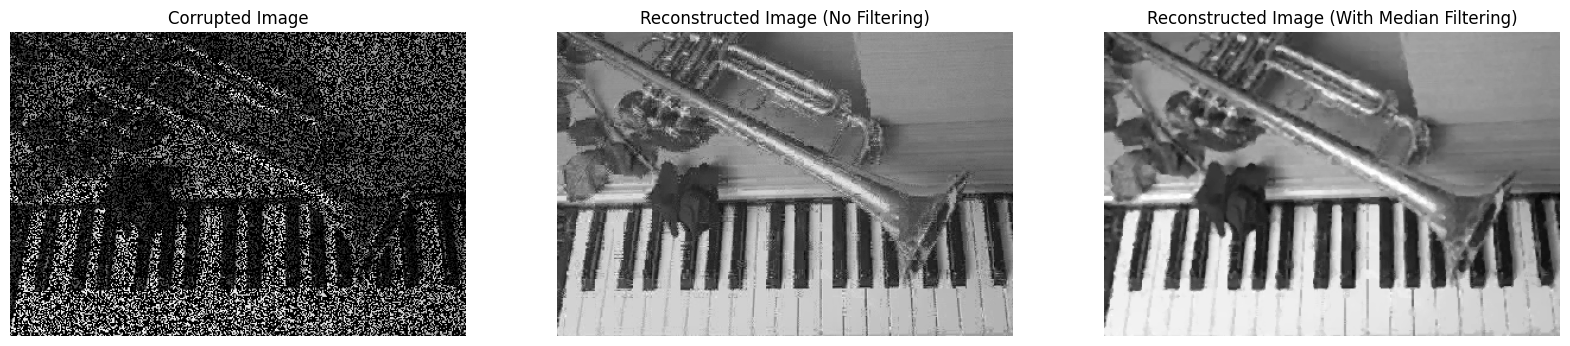

In [19]:
# Optimal alpha value
alpha = 3e-3

# Get the vector matrix
B = get_basis_vector_matrix(K=8)

# Reconstruct image
image_reconstruction(image_array, alpha=alpha, B=B)